# Meta and imports

In [1]:
# First import main import than run cell with data generator than import io from skimage

In [2]:
# channel indexes
# mask - 0 
# NEW
["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
[ 1,     2,    3,    4,    5,    6,    7,    8,    9,    10,   11,   12,   13  ]
# OLD
["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
[ 14,    15,   16,   17,   18,   19,   20,   21,   22,   23,   24,   25,   26  ]

[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

In [3]:
# class code in sample : index in Y array
# Код	Обозначение	Базовое описание
# Сплошная рубка	1	-
# Проходная рубка	2	-
# Лесная дорога	3	-
# Ветровал	4	-
# Пожар	5	-
# Усыхание (повреждение)	6	Любое повреждение растительности, которое видно на снимке, 
# но сложно понять причину (например повреждение вредителями, или усыхание вследствие потопления и т.д.)
# Выборочная рубка	7	-

classesDict = {
    1: 0, 
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    6: 5,
    7: 6,
}

num_classes = 7 + 1 # all classes count + background

In [4]:
# import cv2

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (EarlyStopping, 
                                        ModelCheckpoint, 
                                        ReduceLROnPlateau, 
                                        CSVLogger, 
                                        TensorBoard,
                                        LearningRateScheduler
                                       )
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
import numpy as np
import glob
import os
from matplotlib import pyplot as plt

from skimage import io

In [5]:
%matplotlib inline

In [6]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Model training

## Model create

In [7]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    #x = Dropout(0.5)(x)#my add default None
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
   # x = Dropout(0.5)(x)#my add default None
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def build_model(size = 256,channels=6):
    
    num_filters = [16, 32, 48, 64] # original
    #num_filters = [16, 32] # custom 
    inputs = Input((size, size, channels))

    skip_x = []
    x = inputs

    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)
        ## My add ##
        x = Dropout(0.5)(x) # 
        #########

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        ## My add ##
        x = Dropout(0.5)(x)
        #########
        x = conv_block(x, f)

    ## Output
    x = Conv2D(num_classes, 1, padding="same")(x)
    x = Activation("softmax")(x)

    return Model(inputs, x)


## Metrics

In [8]:
def iou(y_true, y_pred):
     def f(y_true, y_pred):
         intersection = (y_true * y_pred).sum()
         union = y_true.sum() + y_pred.sum() - intersection
         #x = (intersection + 1e-15) / (union + 1e-15)
         x = (intersection + 1) / (union + 1)
         x = x.astype(np.float32)
         return x
     return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [9]:
import tensorflow.keras.backend as K
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## Callbacks

In [10]:
def lr_schedule(epoch,lr):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    
    # maker by cosine sheduler
    lr = 0.001
    if epoch > 250:
        lr *= 0.5e-3
    elif epoch > 150:
        lr *= 1e-3
    elif epoch > 80:
        lr *= 1e-2
    elif epoch > 30:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)
#lr_scheduler = LearningRateScheduler(lr_schedule_cos)

callbacks = [
          ModelCheckpoint("files/model.h5"),
          ReduceLROnPlateau(monitor='loss',factor=0.1, patience=5,min_lr=1e-7, mode='min'),
          lr_scheduler,
          CSVLogger("files/data.csv"),
          #TensorBoard(),
          EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False)
]

## Training

In [11]:
del model

NameError: name 'model' is not defined

In [12]:
model = build_model(size=256,channels=16)
#model = unet(input_size=(256,256,6))
lr = 1e-1

#opt = tf.keras.optimizers.Adam(learning_rate=lr)
opt = tf.keras.optimizers.Adam()
##########################################
#cosin 
#decay_steps = 10
#lr_decayed_fn = (
#  tf.keras.experimental.LinearCosineDecay(
#    lr, decay_steps))
##########################################

#opt = tf.keras.optimizers.Adam(lr_decayed_fn)

metrics = [dice_coefficient, 'accuracy']


model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics)
#model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=metrics)

In [152]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 16 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 2320        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [100]:
print(len(list(glob.glob(f'..\\ML_FOREST\\ds\\**\\*with_object.tif', recursive=True))))
print(len(list(glob.glob(f'..\\ML_FOREST\\ds\\**\\*.tif', recursive=True))))

5279
9013


In [17]:
batch = 40

epochs = 50

# folder where dates is intermidiate in season
# with show -> without snow
# without show -> with snow
"""flds = [
    
]"""


# summer folders
# without snow -> without snow
"""flds = [

]"""

# winter changes
# with snow -> with snow
"""flds = [
]"""

allTifs = []

# get all tifs from train folder
#allTifs = list(glob.glob('../../ds/tiles_256_256_27/*/*.tif'))

# with object tiffs
#allTifs = list(glob.glob('../../ds/tiles_256_256_27/*/*with_object.tif'))

# add tiles + checked tiles

# take base data by specific season
# for fldName in flds:
#     # allTifs.extend(list(glob.glob(f'../../ds/tiles_256_256_27_after_check/{fldName}/*.tif')))
#     allTifs.extend(list(glob.glob(f'./withobject/*/*.tif')))

# delete control data
# notControl = ['noobject']
# addTiles = []
# for tile in list(glob.glob(f'./noobject_not_random/*/*.tif')):
#     tileName = os.path.basename(tile)
#     #print(tileName[:6])
#     if tileName[:6] in notControl:
#         addTiles.append(tile)

# allTifs = (
#     list(glob.glob(f'../../ds/tiles_256_256_27_after_check/*/*.tif'))
#     + addTiles
# )

# get all tiffs from defined list
#allTifs = []
flds = [
    'tiles_256_256_27_add',
    'tiles_256_256_27_additionegor',
    #'tiles_256_256_27_additionegor_noobjmask',
    'tiles_256_256_27_after_check',
    #'tiles_256_256_27_windthrows'
]
for fldName in flds:
    allTifs.extend(list(glob.glob(f'../../ML_FOREST/ds/{fldName}/**/*with_object.tif')))

print(f'До проверки на tif - {len(allTifs)}')
allTifs = [f for f in allTifs if os.path.isfile(f)]
print(f'Послке проверки на tif - {len(allTifs)}')
print(f'Общее количество - {len(allTifs)}')

До проверки на tif - 3831
Послке проверки на tif - 3831
Общее количество - 3831


In [ ]:
#shuffle
np.random.shuffle(allTifs)

#validate 15%
#validate by hist by month
validSize = int(len(allTifs)*0.15)
    
train_generator = DataGenerator(allTifs[:-validSize],batch_size=batch)
valid_generator = DataGenerator(allTifs[-validSize:],batch_size=batch)

hist = model.fit(train_generator,
                    steps_per_epoch=len(allTifs[:-validSize])//batch,
                    validation_data=valid_generator,
                    epochs=epochs,
                    validation_steps=len(allTifs[-validSize:])//batch,
                    callbacks=callbacks
                )

Epoch 1/50
Learning rate:  0.001
81/81 [==============================] - 126s 1s/step - loss: 1.1503 - dice_coefficient: 0.3669 - accuracy: 0.8122 - val_loss: 1.0194 - val_dice_coefficient: 0.3695 - val_accuracy: 0.9649
Epoch 2/50
Learning rate:  0.001
81/81 [==============================] - 114s 1s/step - loss: 0.5094 - dice_coefficient: 0.6509 - accuracy: 0.9627 - val_loss: 0.3844 - val_dice_coefficient: 0.7329 - val_accuracy: 0.9642
Epoch 3/50
Learning rate:  0.001
81/81 [==============================] - 113s 1s/step - loss: 0.3075 - dice_coefficient: 0.7984 - accuracy: 0.9634 - val_loss: 0.2608 - val_dice_coefficient: 0.8537 - val_accuracy: 0.9644
Epoch 4/50
Learning rate:  0.001
81/81 [==============================] - 114s 1s/step - loss: 0.2277 - dice_coefficient: 0.8639 - accuracy: 0.9635 - val_loss: 0.2282 - val_dice_coefficient: 0.8923 - val_accuracy: 0.9646
Epoch 5/50
Learning rate:  0.001
81/81 [==============================] - 114s 1s/step - loss: 0.1869 - dice_coeffic

In [2]:
import pandas as pd
model.save('./AllMyUnet_FewClasses_WithObjects.h5')
hist_df = pd.DataFrame(hist.history) 
hist_df.to_csv('./AllMyUnet_FewClasses_WithObjects.csv')

NameError: name 'model' is not defined

AttributeError: 'DataFrame' object has no attribute 'epoch'

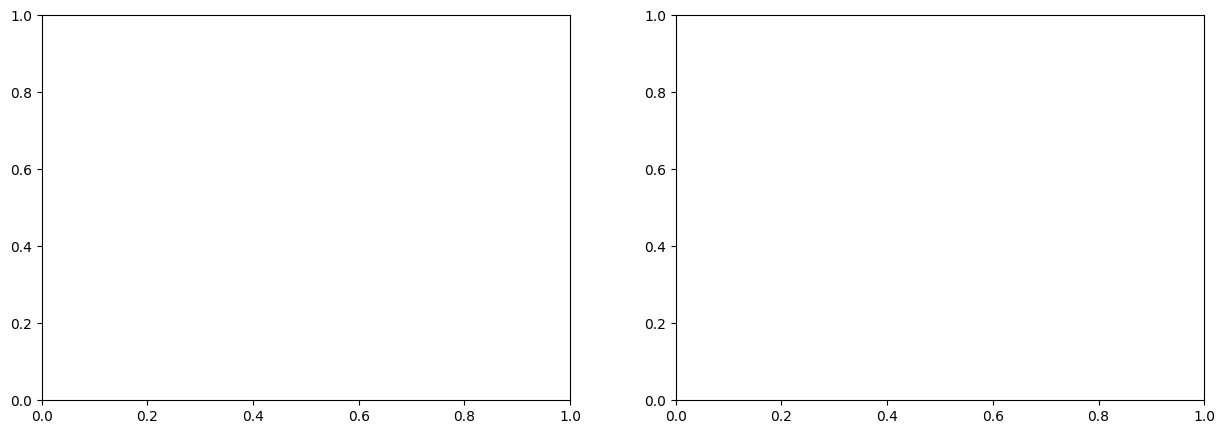

In [8]:
df = pd.read_csv('./AllMyUnet_FewClasses.csv')
history = df
#history = hist
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["dice_coefficient"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_dice_coefficient"], label="Validation accuracy")

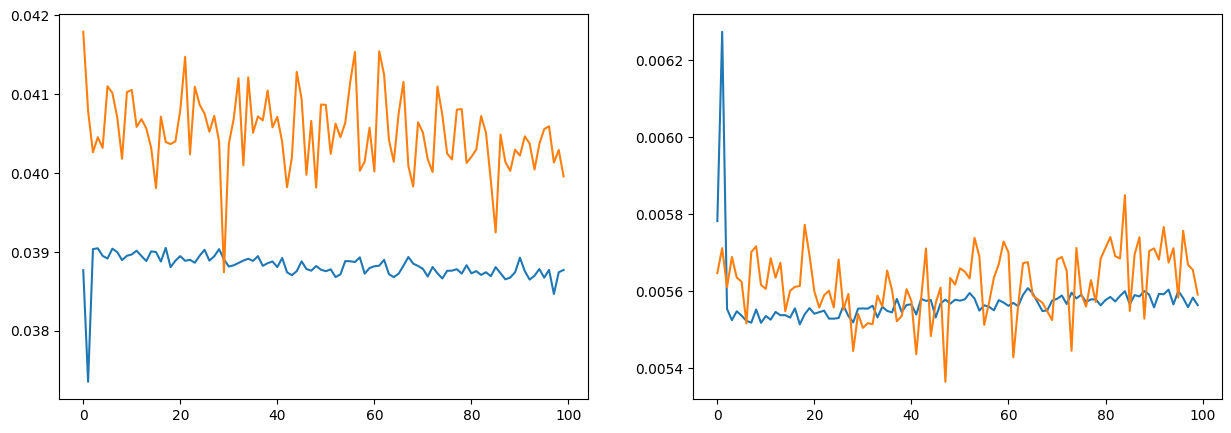

In [11]:
df = pd.read_csv('./AllMyUnet_FewClasses.csv')
history = df

fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history['Unnamed: 0'], history["loss"], label="Train loss")
ax_loss.plot(history['Unnamed: 0'], history["val_loss"], label="Validation loss")
ax_acc.plot(history['Unnamed: 0'], history["dice_coefficient"], label="Train accuracy")
ax_acc.plot(history['Unnamed: 0'], history["val_dice_coefficient"], label="Validation accuracy")

# Test prediction

In [11]:
model  = tf.keras.models.load_model('./AllMyUnet_FewClasses.h5',compile=False)

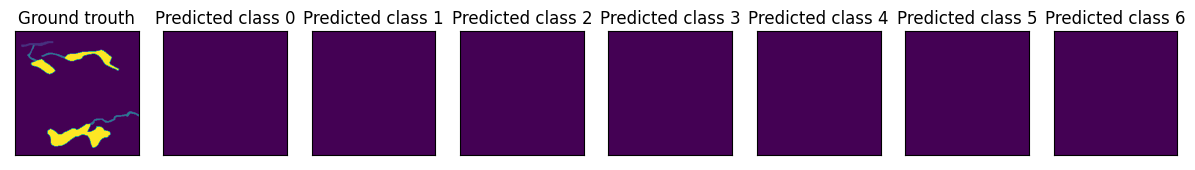

In [43]:
testImg = (
'../ML_FOREST/ds/tiles_256_256_27_additionegor/T35WPQ_pair_0_20170702_20180702/T35WPQ_pair_0_20170702_20180702_8319_9359_with_object.tif')

mask = io.imread(testImg)[:,:,0]
img = io.imread(testImg)/65536

#add zeros mask to fill empty mask channel
img = np.insert(img,0, np.zeros((256,256)),axis=2)
#print (img.shape)
            
toPredict = np.array(
                np.dstack([
                   #img[:,:,17],# old red
                    #img[:,:,21], # new red
                    #img[:,:,25], # new red
                    #img[:,:,26], # new red
                    # separate new
                    img[:,:,4],
                    #img[:,:,5],
                    #img[:,:,6],
                    #img[:,:,7],
                    img[:,:,8],
                    img[:,:,17],
                    img[:,:,21],
                    # separate old
                    #img[:,:,17],
                    #img[:,:,18],
                    #img[:,:,19],
                    #img[:,:,20],
                    #img[:,:,21],
                    #img[:,:,26],
                    img[:,:,4] - img[:,:,17], # dif red
                    img[:,:,17] - img[:,:,4], # dif for transitionChange
                    #img[:,:,8],
                    #img[:,:,21],
                    #img[:,:,13],
                    img[:,:,8] - img[:,:,21],
                    img[:,:,21] - img[:,:,8],
                    #(
                    #   (img[:,:,8] - img[:,:,4]) /((img[:,:,8] + img[:,:,4])+ 0.0001)- # new ndvi
                    #   (img[:,:,21] - img[:,:,17])/((img[:,:,21] + img[:,:,17])+0.0001) # old ndvi
                    #), # ndvi diff
                    #swvi dif
                    #(
                    #    (img[:,:,8] - img[:,:,13]) /((img[:,:,8] + img[:,:,13])+0.0001)-   # new swir
                    #    (img[:,:,21] - img[:,:,26])/((img[:,:,21] + img[:,:,26])+0.0001)  # old swir
                        
                    #),
                    #swvi dif 
                    #(
                    #    (img[:,:,21] - img[:,:,26])/((img[:,:,21] + img[:,:,26])+0.0001) -
                    #    (img[:,:,8] - img[:,:,13]) /((img[:,:,8] + img[:,:,13])+0.0001)   # new swir
                         # old swir
                        
                    #),
                    
                    img[:,:,13],
                    img[:,:,26],
                    img[:,:,13] - img[:,:,26],
                    img[:,:,26] - img[:,:,13], # dif for transitionChange
                    img[:,:,12], # dif for transitionChange
                    img[:,:,25], # dif for transitionChange
                    img[:,:,12] - img[:,:,25], # dif for transitionChange
                    img[:,:,25] - img[:,:,12], # dif for transitionChange26] - img[:,:,13], # dif for transitionChange
                    
                    
                    
                ]).astype('float32'))

testPrediction = model.predict(np.array([toPredict]))

#display output
fig,axes = plt.subplots(ncols=len(classesDict) + 1 ,figsize=(15,15))

#display without probality condition
#axes[0].imshow(np.where(testPrediction[0].astype('float32')>0.5,1,0))

#display with probality condition
axes[0].imshow(mask)
axes[0].xaxis.set_ticks([])
axes[0].yaxis.set_ticks([])
axes[0].set_title('Ground trouth')

for idx, cls in enumerate(classesDict,1):
     axes[idx].imshow((testPrediction[0][:,:,idx-1]>0.15))
     axes[idx].xaxis.set_ticks([])
     axes[idx].yaxis.set_ticks([])
     axes[idx].set_title(f'Predicted class {classesDict[idx]}')

In [81]:
np.unique((testPrediction[0][:,:,0]>0.177).astype(int))

array([0, 1])

(array([[ 0.,  1.,  8., ..., 12.,  4.,  0.],
        [ 0.,  0.,  7., ..., 14.,  0.,  0.],
        [ 0.,  0.,  6., ..., 11.,  1.,  0.],
        ...,
        [ 0.,  1.,  6., ...,  5.,  1.,  0.],
        [ 0.,  1.,  8., ..., 13.,  0.,  0.],
        [ 0.,  5., 30., ...,  3.,  0.,  0.]]),
 array([0.17554623, 0.17582315, 0.17610009, 0.17637701, 0.17665395,
        0.17693087, 0.1772078 , 0.17748474, 0.17776166, 0.1780386 ,
        0.17831552]),
 <a list of 256 BarContainer objects>)

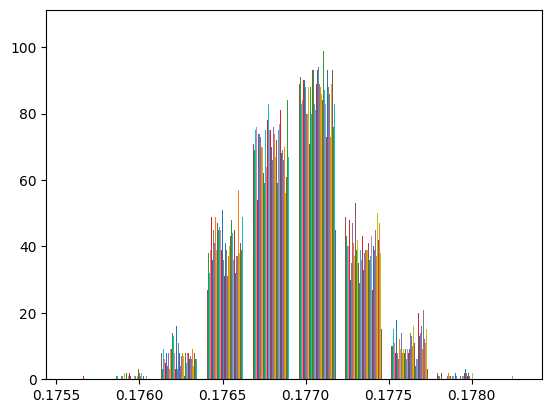

In [79]:
plt.hist(testPrediction[0][:,:,0])

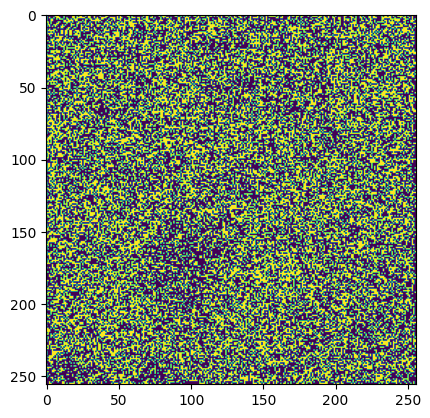

In [82]:
plt.imshow((np.where(testPrediction[0][:,:,0]>0.177, 1,0)))

In [32]:
#testPrediction[0].shape
np.unique(testPrediction[0][:,:,6])


array([0.23073624, 0.23416899, 0.25684524, ..., 0.4982294 , 0.4982877 ,
       0.5055486 ], dtype=float32)

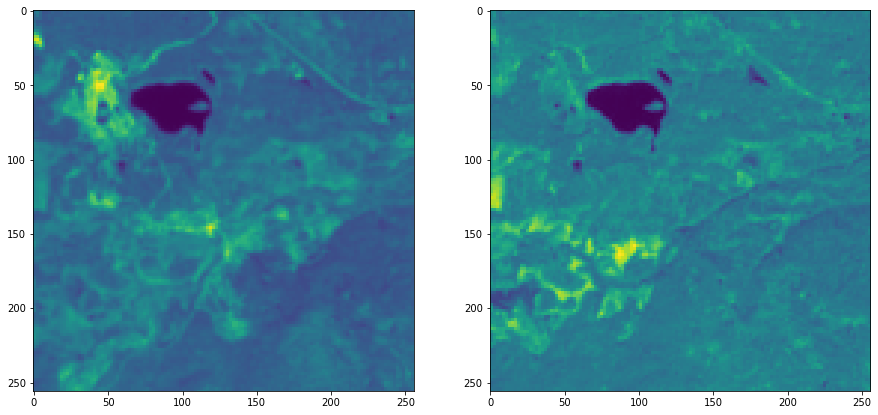

In [44]:
fig,axes = plt.subplots(ncols=2,figsize=(15,15))
#%matplotlib inline
#plt.imshow(testPredcition[0])
#axes[0].imshow((img[:,:,8] - img[:,:,13]) /((img[:,:,8] + img[:,:,13]) + 0.0001))
#axes[1].imshow((img[:,:,21] - img[:,:,26])/((img[:,:,21] + img[:,:,26])+ 0.0001))

axes[0].imshow(img[:,:,13])
axes[1].imshow(img[:,:,21])
#np.unique(testPrediction[0])

In [ ]:
tf.keras.utils.plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [ ]:
train_generator = DataGenerator(allTifs[:-validSize],batch_size=batch)

In [ ]:
df.iloc[0]

Unnamed: 0              1.000000
0.026183055713772774    0.025647
0.23869885504245758     0.095357
0.001                   0.001000
0.019560953602194786    0.018433
0.16562528908252716     0.076893
Name: 0, dtype: float64

In [ ]:
len(train_generator[0][1])

32

# Custom data generator

In [16]:
#import imgaug as ia
from imgaug import augmenters as iaa
from tensorflow.keras.utils import to_categorical
# 
class DataGenerator(tf.keras.utils.Sequence):
    """
    Custom data generator for Unet PermForestChange
    
    Main parameter is unputTiffs - list to path to tiff files
    
    Sample usage 
    allTifs = list(glob.glob('../../ds/tiles_256_256_27/*/*.tif'))

    validSize = 250
    
    train_generator = DataGenerator(allTifs[:-validSize],batch_size=batch)
    
    """
    def __init__(self, inputTiffs, batch_size=32, num_classes=2, shuffle=True):
        self.inputTiffs = inputTiffs
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        #custom augmentation with imgaug lib
        self.aug_pipe = iaa.Sequential(
            [
                iaa.SomeOf((0,2),
                [
                    #iaa.Add((-30, -10)), # change brightness of images (by -10 to 10 of original value)
                    #iaa.Multiply((0.8, 1.2)),
                    
                    # Geometric transfroms
                    iaa.Rotate((-45,45)),
                    iaa.TranslateX(px=(-20, 20)),
                    iaa.TranslateY(px=(-20, 20)),
                ]
                ),
            ],
            random_order=True
        )

    def __len__(self):
        return len(self.inputTiffs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        #print (indexes)
        batchTifs = [self.inputTiffs[k] for k in indexes]
        
        X, y = self._get_data(batchTifs)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.inputTiffs))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def _get_data(self, batch):
        #X = inArray
        #y = # logic
        
        X = []
        y = []
        tifNames = []
        
        for idx,imagePath in enumerate(batch):
            
            #print (image)
            
            # raw image
            img = io.imread(imagePath)
            mask = img[:,:,0]
            img = (img/65536).astype('float32')
            
            # flip with cv2
            #flip = np.random.binomial(1, .5)
            #if flip > 0.5:
                #img = self.flip(img)
            
            # aug with imgaug lib
            #img = self.aug_pipe.augment_image(img)
            
            # x with features
            # channel indexes
            # mask - 0 
            # NEW
            #["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
            #[ 1,     2,    3,    4,    5,    6,    7,    8,    9,    10,   11,   12,   13  ]
            # OLD
            #["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
            #[ 14,    15,   16,   17,   18,   19,   20,   21,   22,   23,   24,   25,   26  ]
            X.append(np.array(
                np.dstack([
#img[:,:,17],# old red
                    #img[:,:,21], # new red
                    #img[:,:,25], # new red
                    #img[:,:,26], # new red
                    
                    # separate new
                    img[:,:,4],
                    #img[:,:,5],
                    #img[:,:,6],
                    #img[:,:,7],
                    img[:,:,8],
                    #img[:,:,13],
                    # separate old
                    img[:,:,17],
                    #img[:,:,18],
                    #img[:,:,19],
                    #img[:,:,20],
                    img[:,:,21],
                    #img[:,:,26],
                    #
                    img[:,:,4] - img[:,:,17], # dif red
                    img[:,:,17] - img[:,:,4], # dif for transitionChange
                    #img[:,:,8],
                    #img[:,:,21],
                    #img[:,:,13],
                    img[:,:,8] - img[:,:,21],
                    img[:,:,21] - img[:,:,8],
                    #(
                    #    (img[:,:,8] - img[:,:,4]) /((img[:,:,8] + img[:,:,4])+ 0.0001)- # new ndvi
                    #    (img[:,:,21] - img[:,:,17])/((img[:,:,21] + img[:,:,17])+0.0001) # old ndvi
                    #), # ndvi diff
                    #swvi dif
                    #(
                    #    (img[:,:,8] - img[:,:,13]) /((img[:,:,8] + img[:,:,13])+0.0001)-   # new swir
                    #    (img[:,:,21] - img[:,:,26])/((img[:,:,21] + img[:,:,26])+0.0001)  # old swir
                        
                    #),
                    #swvi dif 
                    #(
                    #    (img[:,:,21] - img[:,:,26])/((img[:,:,21] + img[:,:,26])+0.0001) -
                    #    (img[:,:,8] - img[:,:,13]) /((img[:,:,8] + img[:,:,13])+0.0001)   # new swir
                         # old swir
                        
                    #),
                    
                    img[:,:,13],
                    img[:,:,26],
                    img[:,:,13] - img[:,:,26],
                    img[:,:,26] - img[:,:,13], # dif for transitionChange
                    img[:,:,12], # dif for transitionChange
                    img[:,:,25], # dif for transitionChange
                    img[:,:,12] - img[:,:,25], # dif for transitionChange
                    img[:,:,25] - img[:,:,12], # dif for transitionChange
                    #(get_value_by_extent(imagePath))/100.0
                    
                    
                ])).astype('float32'))
            
            # to one class all changes
            #y.append(np.where(img[:,:,0]>0,1,0).astype('int'))
            y.append(to_categorical(mask, num_classes=num_classes))
            
        return np.array(X), np.array(y)
    
    def flip(self,image):
        """
        Random flip image around x, y or both axes
        image is np.array
        """
        flipDirection = np.random.randint(-1,1,1)[0]
        #return cv2.flip(image,flipDirection)
        
        

# Testing custom generator

In [8]:
testGen = DataGenerator(list(glob.glob('../../ML_FOREST/ds/tiles_256_256_27_add/**/*with_object.tif')),batch_size=8)

In [9]:
testGen[0][2][0]

'../../ML_FOREST/ds/tiles_256_256_27_add\\T38VPL_pair_0_2018_06_17_2018_08_01.tif\\T38VPL_pair_0_2018_06_17_2018_08_01.tif_6222_5505_with_object.tif'

In [24]:
np.unique(testGen[0][1][0][:,:,1])

array([0], dtype=int8)

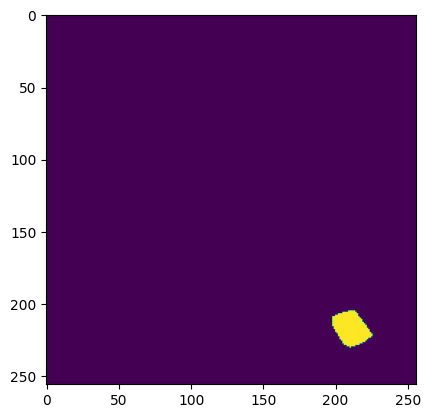

In [10]:
plt.imshow(testGen[0][1][0][:,:,0])

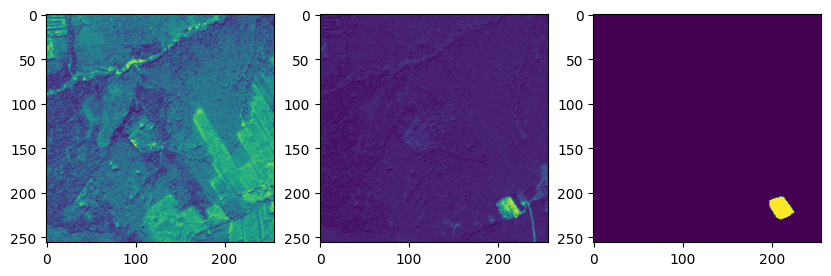

In [24]:
plt.figure(figsize=(10, 3.5))

plt.subplot(1,3,1)
plt.imshow(testGen[0][0][0][:,:,1])

plt.subplot(1,3,2)
plt.imshow(testGen[0][0][0][:,:,0])

plt.subplot(1,3,3)
plt.imshow(testGen[0][1][0][:,:,0])

# несколько каналов
# fig, ax = plt.subplots(1,2, figsize=(10, 3.5))
# for i, axi in enumerate(ax.flat):
#     axi.imshow(testGen[0][0][0][:,:,i])

TypeError: Invalid shape (256, 256, 7) for image data

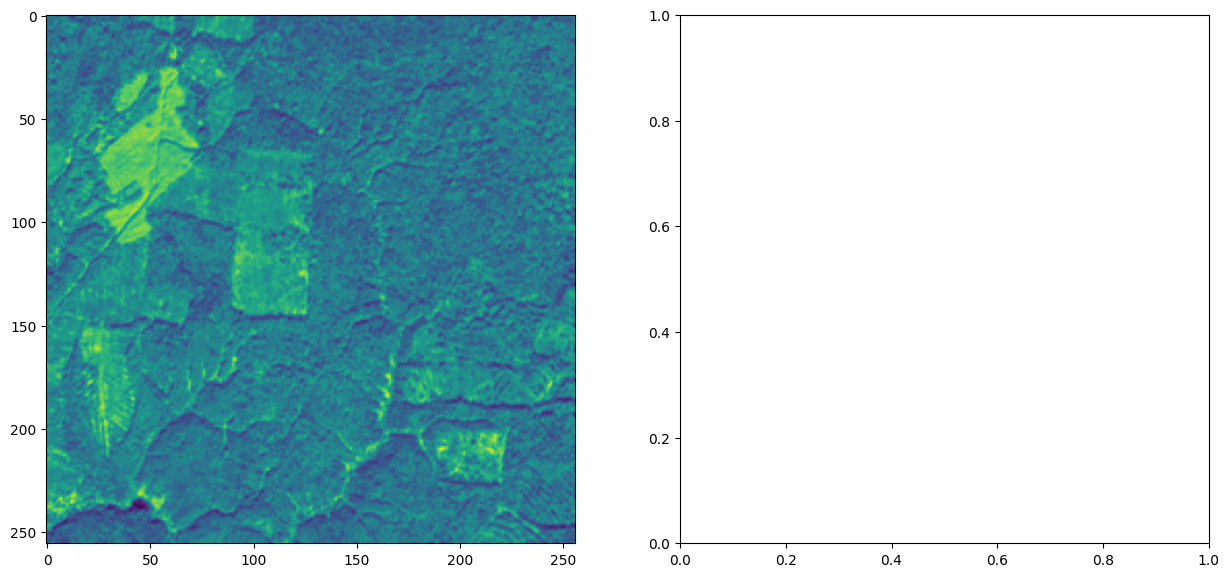

In [16]:
from matplotlib import pyplot as plt

imgIdx = 0
batchNum = 2
testImg = (testGen[batchNum][0][imgIdx][:,:,1]*65536)
testMask = testGen[batchNum][1][imgIdx]
fig,axes = plt.subplots(ncols=2,figsize=(15,15))
axes[0].imshow(testImg)
axes[1].imshow(testMask)

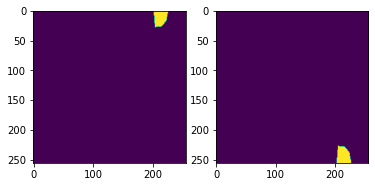

In [ ]:
from matplotlib import pyplot as plt
import glob
import cv2
from skimage import io
testFlipImage = list(glob.glob('../../ds/tiles_256_256_27/*/*.tif'))[0]
img = io.imread(testFlipImage)
flipped=cv2.flip(img,0)
fig,axes = plt.subplots(ncols=2)
axes[0].imshow(flipped[:,:,0])
axes[1].imshow(img[:,:,0])

In [ ]:
img = io.imread('../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/'+
                   'T39VVJ_pair_0.tif_10091_3559_with_object.tif')

In [ ]:
tempCalck = np.array(
                np.dstack([
                    img[:,:,17],# old red
                    img[:,:,4], # new red
                    img[:,:,4] - img[:,:,17], # dif
                    img[:,:,8],
                    img[:,:,21],
                    img[:,:,8] - img[:,:,21],
                    (
                        (img[:,:,21] - img[:,:,17])/(img[:,:,21] + img[:,:,17])-
                        (img[:,:,8] - img[:,:,4])/ (img[:,:,8] + img[:,:,4])
                        
                    ), # ndvi diff
                    
                ])).astype('float32')

# Test flatt y

In [ ]:
classesDict = {
    1: 0, 
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    6: 5,
    7: 6,
}

In [ ]:
testTile = './withobject/T35WPQ_pair_0_20170702_20180702/T35WPQ_pair_0_20170702_20180702_6297_7056_with_object.tif'
testArray = io.imread(testTile)
testArray.shape

(256, 256, 27)

In [ ]:
np.unique(testArray[:,:,0])

array([0, 3, 7], dtype=int16)

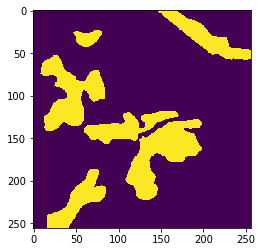

In [30]:
%matplotlib inline
plt.imshow(np.where(testArray[:,:,0] == 7, 7,0))

In [34]:
template = np.zeros((256,256, len(classesDict)),dtype=np.int8)
template.shape

(256, 256, 7)

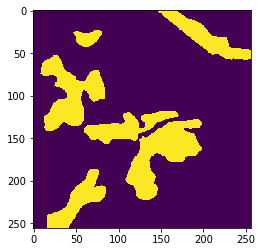

In [35]:
template[:,:, classesDict[7]] = np.where(testArray[:,:,0] == 7, 7,0)
plt.imshow(template[:,:, 6])

In [32]:
np.unique(template[:,:, 6])

array([0., 7.])

In [42]:
classes = np.unique(testArray[:,:,0])
template = np.zeros((256, 256, len(classesDict)), dtype=np.int8)
for cls in classes:
    if cls == 0:
        continue
    template[:,:,classesDict[cls]] = np.where(testArray[:,:,0] == cls, 1,0)

In [43]:
np.unique(template[:,:, 2])

array([0, 1], dtype=int8)

In [ ]:

plt.imshow(tempCalck[:,:,6].astype('float32'))

In [47]:
(img[:,:,21] - img[:,:,17])/(img[:,:,21] + img[:,:,17])

array([[0.11824394, 0.11828825, 0.13282556, ..., 0.15109296, 0.15732648,
        0.13275271],
       [0.12171332, 0.12021519, 0.11128588, ..., 0.13801694, 0.11950697,
        0.10991669],
       [0.12847682, 0.11763472, 0.11460488, ..., 0.13073852, 0.10353936,
        0.10635042],
       ...,
       [0.17748918, 0.18011758, 0.16649378, ..., 0.12227896, 0.14371749,
        0.1702292 ],
       [0.17508583, 0.17726887, 0.19292517, ..., 0.11939492, 0.15245478,
        0.16315933],
       [0.14742015, 0.21019457, 0.1485426 , ..., 0.13832553, 0.13329876,
        0.12221672]])

In [4]:
import glob
list(glob.glob('../../ds/tiles_256_256_27/*/*with_object.tif'))

['../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_749_8648_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_685_8649_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_1897_9329_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_2338_6774_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_2390_9789_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_3273_5181_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_3350_9754_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_5243_7308_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_5845_10641_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_5978_10836_with_object.tif',
 '../../ds/tiles_256_256_27/T39VVJ_pair_0.tif/T39VVJ_pair_0.tif_6158_5891_with_o

# Test loss func

In [131]:
testGen = DataGenerator(list(glob.glob('../../ML_FOREST/ds/tiles_256_256_27_add/**/*with_object.tif')),batch_size=8)

In [22]:
from tensorflow import keras

In [87]:
cce = tf.keras.losses.CategoricalCrossentropy(
    #reduction=tf.keras.losses.Reduction.NONE, 
    axis=1
)

In [138]:
for i in range(7):
    print(np.max(testGen[0][1][5][:,:,i]))

1.0
0.0
0.0
0.0
0.0
0.0
0.0


In [48]:
# testGen[0][1][1][:,:,0].reshape(-1).dtype
#testGen[0][1][1].shape
# testGen[0][1][1].dtype
testGen[0][1][5].astype(np.float32).shape

(256, 256, 7)

In [67]:
testGen[0][1][5][:,:,0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [75]:
cce([testGen[0][1][5][:,:,0].reshape(-1)], [testGen[0][1][5][:,:,0].astype(np.float32).reshape(-1)])

<tf.Tensor: shape=(), dtype=float32, numpy=3186.785>

In [140]:
cce([testGen[0][1][5]], [testGen[0][1][5]]).numpy()

nan